In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hubj8w5y
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-hubj8w5y
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=abd30526dee0e225381b20662c65a91867e461502240236b5d63e35deda7f132
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_hfnqs2/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [10]:
# importar librerías
import tensorflow as tf

2024-06-21 19:18:22.204181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 19:18:22.204317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 19:18:22.311195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

# Importar dataset

In [ ]:
!pip install gdown

In [ ]:
import gdown

url = "https://drive.google.com/file/d/1dHpChP3mh0WA-3OdREamvqyRi2pojUIx/view?usp=drive_link"
output = 'sketchy_dataset.7z'
gdown.download(url, output, quiet=False, fuzzy=True)

In [ ]:
# unzipear
!7z x sketchy_dataset.7z

### Funciones

In [3]:
import re as regex

def load_sketchy(image_file):
  #Función para leer y convertir imagen (las 2 que contiene) en tensores
  imagen_sketch = tf.io.read_file(image_file)
  imagen_sketch = tf.io.decode_jpeg(imagen_sketch)

  input_image = tf.cast(imagen_sketch, tf.int32)

  return input_image

In [4]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [5]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [6]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [7]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [8]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

### Dataset

In [14]:
import glob

# Directorios de las carpetas de imágenes
sketch_folder = "/kaggle/working/256*256/sketch/tx_000000000000/seal/*"
photo_folder = "/kaggle/working/256*256/photo/tx_000000000000/seal/*"

# Obtener la lista de rutas de imágenes de cada carpeta usando glob
sketch_images = glob.glob(sketch_folder)
photo_images = glob.glob(photo_folder)

# Crear datasets de TensorFlow con las rutas de las imágenes
sketch_dataset = tf.data.Dataset.from_tensor_slices(sketch_images)
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_images)

# Aplicar la función load_sketchy para cargar y convertir las imágenes en tensores
sketch_dataset = sketch_dataset.map(load_sketchy)
photo_dataset = photo_dataset.map(load_sketchy)

# Convertir datasets a prefetch
#sketch_dataset = sketch_dataset.prefetch(tf.data.experimental.AUTOTUNE)
#photo_dataset = photo_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256

sketch_dataset = sketch_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_dataset = photo_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
def split_dataset(dataset, train_size, val_size):
    dataset_size = len(dataset)
    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)
    return train_dataset, val_dataset, test_dataset

#Porcentaje para cada conjunto
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Número de imágenes
num_sketch_images = len(sketch_dataset)
num_photo_images = len(photo_dataset)

sketch_train_size = int(train_ratio * num_sketch_images)
sketch_val_size = int(val_ratio * num_sketch_images)

photo_train_size = int(train_ratio * num_photo_images)
photo_val_size = int(val_ratio * num_photo_images)

sketch_train, sketch_val, sketch_test = split_dataset(sketch_dataset, sketch_train_size, sketch_val_size)
photo_train, photo_val, photo_test = split_dataset(photo_dataset, photo_train_size, photo_val_size)

In [22]:
print(f"Tamaño de los conjutnos:")
print(f"Sketch Dataset - Train: {len(sketch_train)}, Validation: {len(sketch_val)}, Test: {len(sketch_test)}")
print(f"Photo Dataset - Train: {len(photo_train)}, Validation: {len(photo_val)}, Test: {len(photo_test)}")

Tamaño de los conjutnos:
Sketch Dataset - Train: 452, Validation: 56, Test: 57
Photo Dataset - Train: 80, Validation: 10, Test: 10


In [66]:
#sketch_dataset = sketch_dataset.shuffle(buffer_size=10000) #Solo para que la prueba salga distinta
sample = next(iter(sketch_dataset))


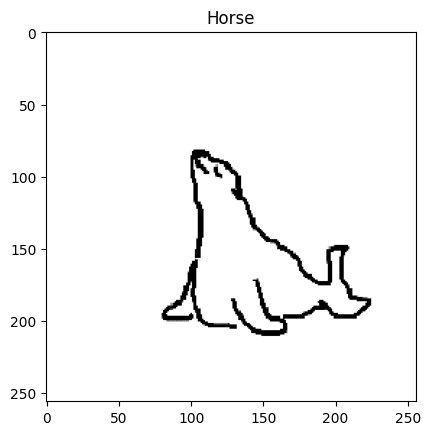

In [17]:
plt.figsize=(10,10)
plt.title('Horse')
plt.imshow(sample[0])

# Modelo

In [23]:
OUTPUT_CHANNELS = 3
#Se sacan los dos discrimadores y generadores del pix2pix importado
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


## Funciones de pérdida

In [24]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#Son iguales a la de pix2pix

In [25]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [26]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [27]:
#Esta ya es distinta. Son las pérdidas del ciclo
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [28]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


## Para checkpoints

In [59]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


## Entrenamiento

In [30]:
EPOCHS = 10

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


In [51]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)
    
    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    #Pérdidas de los generadores
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # La pérdida total del generador es = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    

  #Calcular Gradientes
  generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

  #Aplicar gradientes
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))
  return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss


In [60]:
@tf.function
def val_step(real_x, real_y):
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=False)
    cycled_x = generator_f(fake_y, training=False)

    fake_x = generator_f(real_y, training=False)
    cycled_y = generator_g(fake_x, training=False)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=False)
    same_y = generator_g(real_y, training=False)

    disc_real_x = discriminator_x(real_x, training=False)
    disc_real_y = discriminator_y(real_y, training=False)

    disc_fake_x = discriminator_x(fake_x, training=False)
    disc_fake_y = discriminator_y(fake_y, training=False)

    # Generator losses
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    # Discriminator losses
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [61]:
#Para guardar valores de pérdida
train_gen_g_losses = []
train_gen_f_losses = []
train_disc_x_losses = []
train_disc_y_losses = []

val_gen_g_losses = []
val_gen_f_losses = []
val_disc_x_losses = []
val_disc_y_losses = []

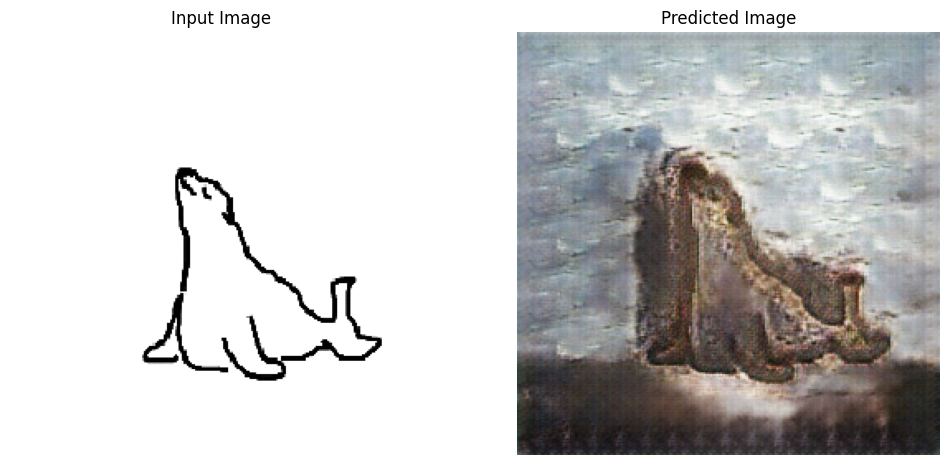

Guardando checkpoint para época 5 en ./checkpoints/train/ckpt-1
Epoch 5, Train Loss: G=3.7085800170898438, F=9.168898582458496, DX=0.02932087890803814, DY=0.5825209021568298
Epoch 5, Val Loss: G=3.7360057830810547, F=9.524200439453125, DX=0.010038161650300026, DY=0.6316143870353699
Time taken for epoch 5 is 50.86791801452637 sec



In [64]:
import time
import numpy as np


for epoch in range(5):
  start = time.time()

#Acumuladores
  epoch_train_gen_g_loss = 0
  epoch_train_gen_f_loss = 0
  epoch_train_disc_x_loss = 0
  epoch_train_disc_y_loss = 0

  epoch_val_gen_g_loss = 0
  epoch_val_gen_f_loss = 0
  epoch_val_disc_x_loss = 0
  epoch_val_disc_y_loss = 0

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((sketch_dataset, photo_dataset)):
    total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss=train_step(image_x, image_y)
    epoch_train_gen_g_loss += total_gen_g_loss
    epoch_train_gen_f_loss += total_gen_f_loss
    epoch_train_disc_x_loss += disc_x_loss
    epoch_train_disc_y_loss += disc_y_loss
    if n % 10 == 0:
      print ('.', end='')
    n += 1
    
    # Validation step
  m = 0
  for image_x, image_y in tf.data.Dataset.zip((sketch_val, photo_val)):
    total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = val_step(image_x, image_y)

    epoch_val_gen_g_loss += total_gen_g_loss
    epoch_val_gen_f_loss += total_gen_f_loss
    epoch_val_disc_x_loss += disc_x_loss
    epoch_val_disc_y_loss += disc_y_loss

    m += 1
    
  epoch_train_gen_g_loss /= n
  epoch_train_gen_f_loss /= n
  epoch_train_disc_x_loss /= n
  epoch_train_disc_y_loss /= n

  epoch_val_gen_g_loss /= m
  epoch_val_gen_f_loss /= m
  epoch_val_disc_x_loss /= m
  epoch_val_disc_y_loss /= m

# Store the losses
  train_gen_g_losses.append(epoch_train_gen_g_loss)
  train_gen_f_losses.append(epoch_train_gen_f_loss)
  train_disc_x_losses.append(epoch_train_disc_x_loss)
  train_disc_y_losses.append(epoch_train_disc_y_loss)

  val_gen_g_losses.append(epoch_val_gen_g_loss)
  val_gen_f_losses.append(epoch_val_gen_f_loss)
  val_disc_x_losses.append(epoch_val_disc_x_loss)
  val_disc_y_losses.append(epoch_val_disc_y_loss)

  clear_output(wait=True)
  generate_images(generator_g, sample)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Guardando checkpoint para época {} en {}'.format(epoch+1,
                                                         ckpt_save_path))
  print(f'Epoch {epoch + 1}, Train Loss: G={epoch_train_gen_g_loss}, F={epoch_train_gen_f_loss}, DX={epoch_train_disc_x_loss}, DY={epoch_train_disc_y_loss}')
  print(f'Epoch {epoch + 1}, Val Loss: G={epoch_val_gen_g_loss}, F={epoch_val_gen_f_loss}, DX={epoch_val_disc_x_loss}, DY={epoch_val_disc_y_loss}')
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


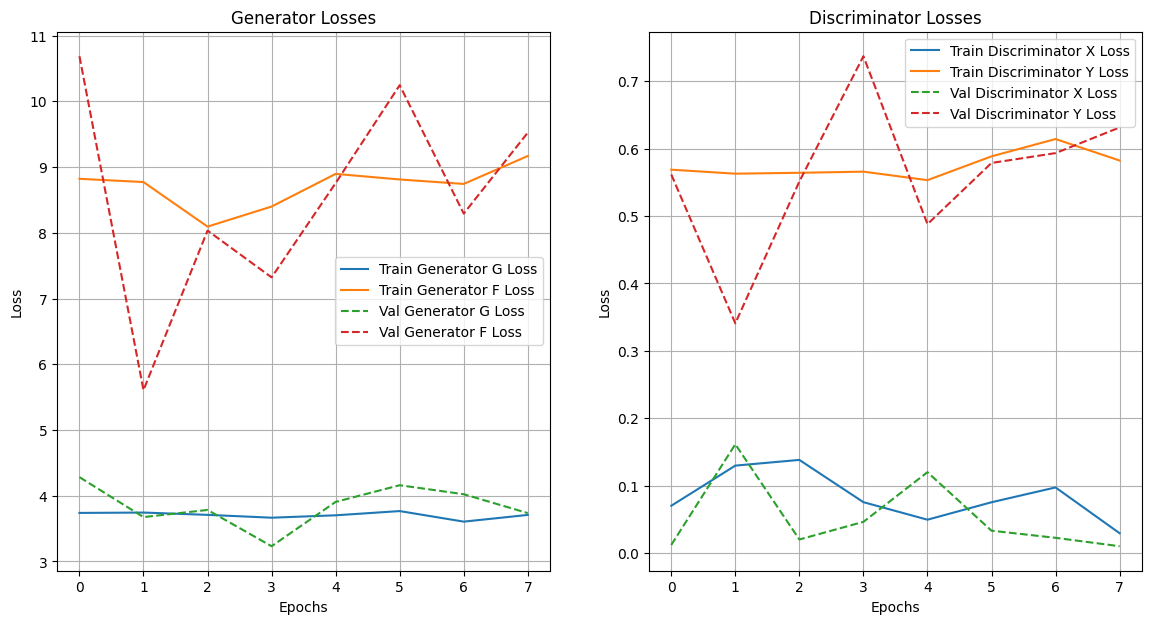

In [65]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_gen_g_losses, label='Train Generator G Loss')
plt.plot(train_gen_f_losses, label='Train Generator F Loss')
plt.plot(val_gen_g_losses, label='Val Generator G Loss', linestyle='--')
plt.plot(val_gen_f_losses, label='Val Generator F Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_disc_x_losses, label='Train Discriminator X Loss')
plt.plot(train_disc_y_losses, label='Train Discriminator Y Loss')
plt.plot(val_disc_x_losses, label='Val Discriminator X Loss', linestyle='--')
plt.plot(val_disc_y_losses, label='Val Discriminator Y Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Losses')
plt.legend()
plt.grid(True)

plt.show()

In [58]:
import os
os.chdir(r'/kaggle/working')


from IPython.display import FileLinks

FileLinks(r'checkpoints')